In [50]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from scipy.fft import fft
import seaborn as sns
%matplotlib inline

In [51]:
%cd "drive/MyDrive/mva/Second Semestre/deep learning in practice/tp/tp5"

[Errno 2] No such file or directory: 'drive/MyDrive/mva/Second Semestre/deep learning in practice/tp/tp5'
/content/drive/MyDrive/mva/Second Semestre/deep learning in practice/tp/tp5


In [52]:
%ls

 final_image.png
 intro_TP5.txt
 model
 model_loss0.061
 model_not_perfect_but_ok
 ode_demo.py
 ode_model.py
 png/
 prefect_model
 __pycache__/
 rossler_map.py
'Selection of Optimal Embedding Parameters JMP_2017083015084865 .pdf'
 time_series.py
 TP.py
'TP-Rössler attractor.pdf'
 traj.npy


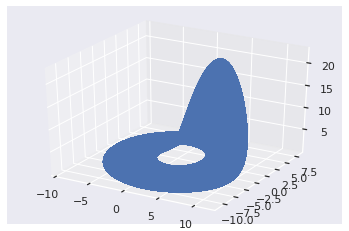

In [53]:
# import newton by the way
%run TP

## Test equilibium and lyapunov with given ground truth

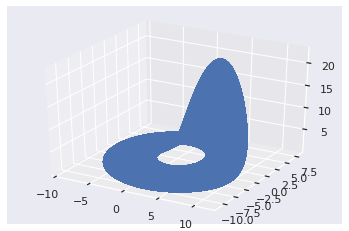

In [54]:
from rossler_map import RosslerMap

# 10 000s and 100 iteration by seconds
Niter = 1000000
delta_t = 1e-2
ROSSLER_MAP = RosslerMap(delta_t=delta_t)
INIT = np.array([-5.75, -1.6,  0.02])
traj,t = ROSSLER_MAP.full_traj(Niter, INIT)


fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(traj[:,0], traj[:,1], traj[:,2])
plt.show()

On fait la trajectoire est stable... donc meme si on part d'un aute point, ça ne change pas vraiment l'information que l'on donne au systeme.

The big period is approximatively 20 seconds in order to go and come back from the second plan

### Visual study of one period

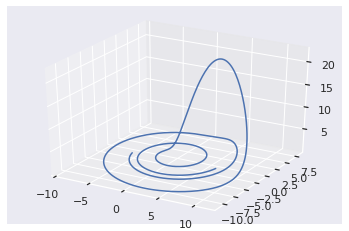

2000

In [55]:
# Calculating the number of time steps necessary to complete one big period
# We then use this value as a batch_time
main_period = int(20 / delta_t)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(traj[:main_period,0], traj[:main_period,1], traj[:main_period,2])
plt.show()

main_period

## Batch Creation

In [56]:
import os
import argparse
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm


class Args:
  data_size = Niter
  batch_time = 2
  batch_size = 50000
  niters = 10000
  test_freq = 100
  gpu = 0

args=Args()

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
device = "cpu"

print("Begin treatement, please wait...")
dim = 3
traj_ = traj.copy()
traj_.resize((Args.data_size, 1, dim))
traj_ = traj_.astype(np.float32)
true_y = torch.from_numpy(traj_)
true_y_ = torch.reshape(true_y, (Args.data_size, 3))
true_y0 = torch.from_numpy(np.array([[-5.75, -1.6,  0.02]]).astype(np.float32)).to(device)
t = torch.linspace(0., max(t), args.data_size).to(device)
print("Done pretreatment")


def get_batch():
    # s tensor (batch_size) of number between 0 and data_size - batch_time
    s = torch.from_numpy(np.random.choice(np.arange(args.data_size - args.batch_time, dtype=np.int64), args.batch_size, replace=False))

    # initialisation of the short time series
    batch_y0 = true_y[s]  # (M, dim)

    # We create (batch_size, batch_time) time series
    batch_y = torch.stack([true_y[s + i] for i in range(args.batch_time)], dim=0)  # (T, M, D)

    batch_y_dot = (batch_y[1] - batch_y[0]) / delta_t

    batch_y0 = torch.reshape(batch_y0, (Args.batch_size, 3))
    batch_y_dot = torch.reshape(batch_y_dot, (Args.batch_size, 3))

    return batch_y0.to(device), batch_y_dot.to(device)


def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

Begin treatement, please wait...
Done pretreatment


In [57]:
batch_y0, batch_y_dot = get_batch()

batch_y0.shape, batch_y_dot.shape

(torch.Size([50000, 3]), torch.Size([50000, 3]))

## Architecture

In [58]:
%load_ext autoreload
%autoreload 2

from ode_model import ODEFunc
func = ODEFunc().to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
pytorch_total_params = sum(p.numel() for p in func.parameters())
pytorch_total_params

183

## Visualization

In [60]:
def visualize(true_y, pred_y_, itr, duration = 1728):
    sns.set()

    fig = plt.figure(figsize=(16, 12), facecolor='white')
    fig.subplots_adjust(top=0.95)
    ax_traj = fig.add_subplot(4,3,1)
    ax_phase = fig.add_subplot(4,3,2)
    ax_3d = fig.add_subplot(4,3,3, projection='3d')
    hist_x = fig.add_subplot(4,3,4)
    hist_y = fig.add_subplot(4,3,5)
    hist_z = fig.add_subplot(4,3,6)
    time_corr_x = fig.add_subplot(4,3,7)
    time_corr_y = fig.add_subplot(4,3,8)
    time_corr_z = fig.add_subplot(4,3,9)
    fft_x = fig.add_subplot(4,3,10)
    fft_y = fig.add_subplot(4,3,11)
    fft_z = fig.add_subplot(4,3,12)
    fig.suptitle('Analysis of Rossler dynamical system. (Green : baseline, Red : Prediction)')

    time = t.cpu().numpy()
    predx = pred_y_[:, 0]
    predy = pred_y_[:, 1]
    predz = pred_y_[:, 2]
    truex = true_y.cpu().numpy()[:, 0]
    truey = true_y.cpu().numpy()[:, 1]
    truez = true_y.cpu().numpy()[:, 2]
    
    ax_traj.cla()
    ax_traj.set_title('Time trajectories (x-, y--, z-.)')
    ax_traj.set_xlabel(f"t {delta_t}s")
    ax_traj.set_ylabel('x,y')
    tmax = 50*100 
    ax_traj.plot(time[:tmax], truex[:tmax],'g', label="true")
    ax_traj.plot(time[:tmax], truey[:tmax], 'g--', label="true")
    ax_traj.plot(time[:tmax], truez[:tmax], 'g-.', label="true")
    ax_traj.plot(time[:tmax], predx[:tmax],'r', label="pred")
    ax_traj.plot(time[:tmax], predy[:tmax], 'r--', label="pred")
    ax_traj.plot(time[:tmax], truez[:tmax], 'r-.', label="true")

    ax_phase.cla()
    ax_phase.set_title('Phase Portrait y=f(x)')
    ax_phase.set_xlabel('x')
    ax_phase.set_ylabel('y')
    ax_phase.plot(truex, truey, 'g-')
    ax_phase.plot(predx, predy, 'r--', alpha=0.5)

    ax_3d.cla()
    ax_3d.set_title('Trajectories')
    ax_3d.plot(truex, truey, truez, 'g-' )
    ax_3d.plot(predx, predy, predz, 'r-', alpha=0.5)

    hist_x.cla()
    hist_x.set_title('x histogram')
    hist_x.hist(truex, color='g')
    hist_x.hist(predx, color='r', alpha=0.5)

    hist_y.cla()
    hist_y.set_title('y histogram')
    hist_y.hist(truey, color='g')
    hist_y.hist(predy, color='r', alpha=0.5)

    hist_z.cla()
    hist_z.set_title('z histogram')
    hist_z.hist(truez, color='g')
    hist_z.hist(predz, color='r', alpha=0.5)
    
    time_corr_x.cla()
    time_corr_x.set_title('Time correlations x')
    time_corr_x.hist2d(truex[duration:], truex[:-duration], cmap="Greens", norm=LogNorm())
    time_corr_x.hist2d(predx[duration:], predx[:-duration], cmap="Reds", norm=LogNorm(), alpha=0.5)

    time_corr_y.cla()
    time_corr_y.set_title('Time correlations y')
    time_corr_y.hist2d(truey[duration:], truey[:-duration], cmap="Greens", norm=LogNorm())
    time_corr_y.hist2d(predy[duration:], predy[:-duration], cmap="Reds", norm=LogNorm(), alpha=0.5)

    time_corr_z.cla()
    time_corr_z.set_title('Time correlations z')
    time_corr_z.hist2d(truez[duration:], truez[:-duration], cmap="Greens", norm=LogNorm())
    time_corr_z.hist2d(predz[duration:], predz[:-duration], cmap="Reds", norm=LogNorm(), alpha=0.5)


    
    max_fft = len(truex)
    #max_fft = 100*100
    fft_x.cla()
    fft_x.set_title('fft x')
    F = lambda x : np.abs(np.real(fft(x)))[:max_fft]
    fft_x.plot(F(truex), color='g')
    fft_x.plot(F(predx), color='r', alpha=0.5)
    fft_x.set_yscale(value="log")
    fft_x.set_xscale(value="log")

    fft_y.cla()
    fft_y.set_title('fft y')
    fft_y.plot(F(truey), color='g')
    fft_y.plot(F(predy), color='r', alpha=0.5)
    fft_y.set_yscale(value="log")
    fft_y.set_xscale(value="log")

    fft_z.cla()
    fft_z.set_title('fft z')
    fft_z.plot(F(truez), color='g')
    fft_z.plot(F(predz), color='r', alpha=0.5)
    fft_z.set_yscale(value="log")
    fft_z.set_xscale(value="log")

    F = lambda x : np.argmax(np.abs(np.real(fft(x)[1:])))+1
    print("Principal frequency truex:", F(truex))
    print("Principal frequency truey:", F(truey))
    print("Principal frequency truez:", F(truez))
    print("Principal frequency predx:", F(predx))
    print("Principal frequency predy:", F(predy))
    print("Principal frequency predz:", F(predz))

    #plt.tight_layout()
    plt.savefig('png/{:03d}'.format(itr))
    plt.draw()
    plt.pause(0.001)


class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

## Utils trajectory computation

In [61]:
from scipy.integrate import solve_ivp
# ROSSLER_MAP.v_eq
#res = solve_ivp(ROSSLER_MAP.v_eq, [0, Niter * 1e-2/10], INIT, method='RK45', t_eval=t[:int(len(t)/10)].cpu().numpy())

def v_eq_pred(t=None, v=None, device=device):
    func.to(device)
    y0 = v
    with torch.no_grad():
        y0 = torch.tensor(y0.astype(np.float32)).to(device)
        y0 = torch.reshape(y0, (1, 3))
        return func(y0)[0].cpu().numpy()

def pred_traj(fraction=10):
    return solve_ivp(v_eq_pred, [0, Niter * 1e-2/fraction], INIT, method='RK45', t_eval=t[:int(len(t)/fraction)].cpu().numpy())["y"]

## Training

In [62]:
from tqdm.notebook import tqdm
%matplotlib inline

print("Niter : ",Niter)
t_MAX = main_period
print("Nb main period for validation" ,t_MAX/main_period)

ii = 0

optimizer = optim.Adam(func.parameters(), lr=1e-2)

Niter :  1000000
Nb main period for validation 1.0


In [63]:
def end_to_end_jacobian_loss(model_output, model_input):
    jacobian = torch.autograd.grad(
        outputs=model_output,
        inputs=model_input,
        grad_outputs=torch.ones(*model_output.shape),
        retain_graph=True,
        only_inputs=True)[0]
    jacobian_norm = jacobian.norm(2)
    return jacobian_norm

In [27]:
optimizer.param_groups[0]['lr'] = 1e-3
for itr in tqdm(range(1, args.niters + 1)):
    optimizer.zero_grad()
    batch_y0, batch_y_dot = get_batch()
    batch_y0_ = batch_y0.clone()
    batch_y0_.requires_grad=True

    pred_y_dot = func(batch_y0_)
    
    J_loss = 0.0001*end_to_end_jacobian_loss(model_output=pred_y_dot, model_input=batch_y0_)
    loss = torch.mean(torch.abs(pred_y_dot - batch_y_dot)) + J_loss

    loss.backward()
    optimizer.step()

    if itr % args.test_freq == 0:
        with torch.no_grad():
            print('Iter {:04d} | {:04d}| Total Loss without Jacobian {:.6f} | J loss {:.6f}'.format(itr,ii, (loss-J_loss).item(), J_loss.item()))
            plt.show()
            ii += 1

Iter 0100 | 0090| Total Loss without Jacobian 0.075120 | J loss 0.120492
Iter 0200 | 0091| Total Loss without Jacobian 0.075063 | J loss 0.120480
Iter 0300 | 0092| Total Loss without Jacobian 0.074220 | J loss 0.120714
Iter 0400 | 0093| Total Loss without Jacobian 0.075726 | J loss 0.120912
Iter 0500 | 0094| Total Loss without Jacobian 0.073226 | J loss 0.121678
Iter 0600 | 0095| Total Loss without Jacobian 0.073072 | J loss 0.121431
Iter 0700 | 0096| Total Loss without Jacobian 0.075238 | J loss 0.121922
Iter 0800 | 0097| Total Loss without Jacobian 0.073969 | J loss 0.122118
Iter 0900 | 0098| Total Loss without Jacobian 0.073643 | J loss 0.122357
Iter 1000 | 0099| Total Loss without Jacobian 0.073171 | J loss 0.122916
Iter 1100 | 0100| Total Loss without Jacobian 0.071272 | J loss 0.122965
Iter 1200 | 0101| Total Loss without Jacobian 0.068730 | J loss 0.122286
Iter 1300 | 0102| Total Loss without Jacobian 0.069975 | J loss 0.123005
Iter 1400 | 0103| Total Loss without Jacobian 0.070

KeyboardInterrupt: ignored

## VIsualisation after training

Principal frequency truex: 1708
Principal frequency truey: 1708
Principal frequency truez: 1708
Principal frequency predx: 1693
Principal frequency predy: 1694
Principal frequency predz: 1693


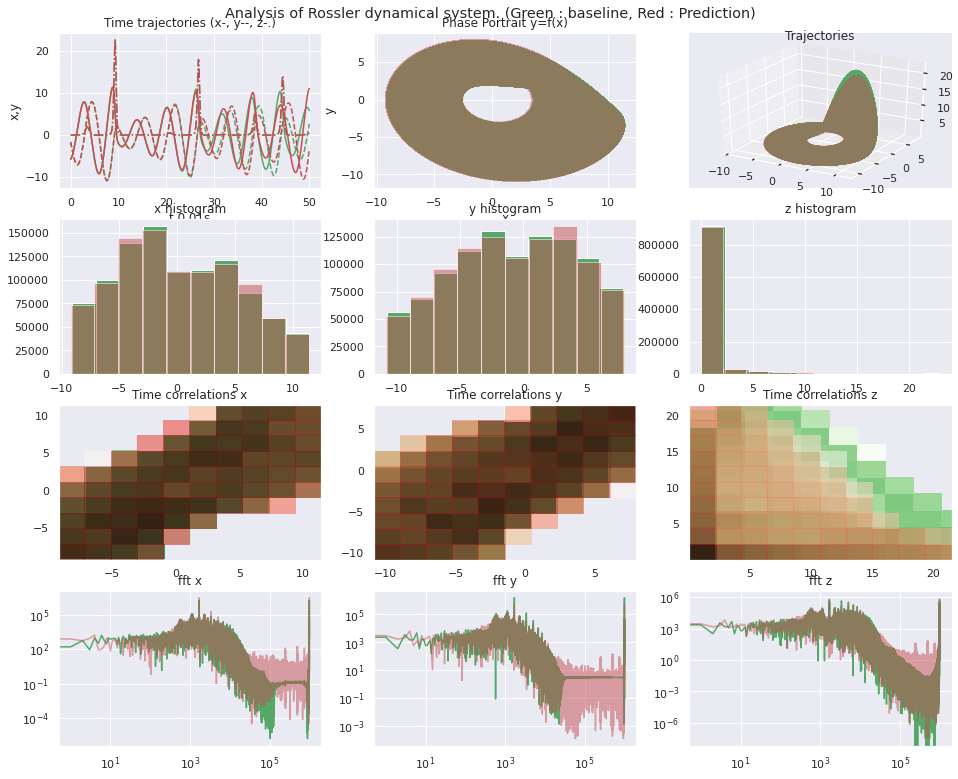

In [33]:
with torch.no_grad():
    pred_y = np.transpose(pred_traj(fraction=1))
    visualize(true_y_[:], pred_y[:], ii, duration = 1708)
    plt.show()

In [34]:
model = func
#PATH = "model_not_perfect_but_ok"
#PATH = "model"
PATH = "final_model"

torch.save(model.state_dict(), PATH)

In [64]:
# Loading the model
#PATH = "model_not_perfect_but_ok"
#PATH = "model_loss0.061"
PATH = "final_model"
from ode_model import ODEFunc
model = ODEFunc()
model.load_state_dict(torch.load(PATH))
model.eval()
func = model

## Jacobian

In [35]:
a=0.2
b=0.2 
c=5.7

def jacobian(v):
    x, z = v[0], v[2]
    res = np.array([[       0,      -1,       -1],
                    [        1,     a,        0],
                    [        z,       0,   x-c]])
    return res

def jacobian_pred(y0, device=device, return_tensor=False):
    """
    # y0 is a numpy array of dim (3,)
    if return_tensor : returns a tensor in order to regularize the frobenius norm
    """
    
    
    y0 = torch.tensor(y0.astype(np.float32))
    y0 = torch.reshape(y0, (1, 3)).to(device)
    func.to(device)

    A = torch.autograd.functional.jacobian(func, y0)[0,:,0,:]
    if return_tensor:
        return A
    return A.cpu().numpy()

A = jacobian_pred(np.zeros(3), return_tensor=True)
A

(tensor([[-1.3808e-02, -9.9511e-01, -6.8899e-01],
         [ 9.8636e-01,  2.1309e-01,  1.0697e+00],
         [-8.3408e-04,  1.8136e-02, -3.9938e+00]]),)

In [36]:
# Sanity check
jacobian(np.zeros(3))

array([[ 0. , -1. , -1. ],
       [ 1. ,  0.2,  0. ],
       [ 0. ,  0. , -5.7]])

## Physical test of the model

In [37]:
fix_point = newton(v_eq_pred,jacobian_pred,INIT)

error = norm(fix_point-ROSSLER_MAP.equilibrium())
print("equilibrium state :", fix_point, ", error : ", error)
plt.show()

equilibrium state : [-0.08080456 -0.05568678  0.04885566] , error :  0.09124225238404277


In [40]:
predicted_traj = np.transpose(pred_traj(fraction=1))

In [41]:
lyap = lyapunov_exponent(predicted_traj, jacobian_pred,
                         max_it=len(predicted_traj), delta_t=delta_t)
print("Lyapunov Exponents :", lyap, "with delta t =", delta_t)

(1000000, 3)
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
Lyapunov Exponents : [ 0.07367473  0.00338464 -3.14234273] with delta t = 0.01


## Test on the final interface

In [71]:
%run time_series.py

Loading : final_model
(3, 1000000)
(1000000,)
